In [1]:
using Revise, LazySets, Plots, Plots.PlotMeasures, LaTeXStrings

In [2]:
using Reachability

┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1184


## Van der Pol model

In [3]:
# =================================================================
# Van der Pol model
# See https://easychair.org/publications/paper/gjfh
# =================================================================

using Reachability, MathematicalSystems, LazySets, TaylorIntegration
using Reachability: solve

@taylorize function vanderPol!(t, x, dx)
    local μ = 1.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

function vanderpol(; X0=Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]),
                     T=7.0,
                     property=(t, x) -> x[2] < 2.75)

    # equations of motion x' = f(x(t))
    F = BlackBoxContinuousSystem(vanderPol!, 2)

    # problem options
    𝑂 = Options(:T=>T, :mode=>"check", :property=>property)
    
    # instantiate problem
    𝑃 = InitialValueProblem(F, X0)

    return 𝑃, 𝑂
end

vanderpol (generic function with 1 method)

## Box overapproximation of the TM flowpipe

In [4]:
# benchmark settings
𝑃, 𝑂 = vanderpol()

# algorithm-specific options
𝑂jets = Options(:abs_tol=>1e-10, :orderT=>10, :orderQ=>2, :max_steps=>500)

# compute reachable sets
@time sol = solve(𝑃, 𝑂, op=TMJets(𝑂jets));

# verify that specification holds
@assert all([ρ([0.0, 1.0], sol.Xk[i].X) < 2.75 for i in eachindex(sol.Xk)])

SubArray{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},2,Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}
103.899179 seconds (106.95 M allocations: 5.768 GiB, 3.87% gc time)


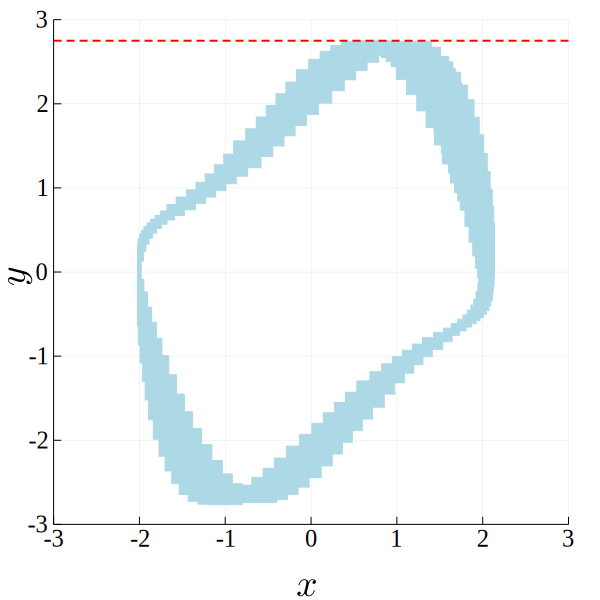

In [12]:
plot(sol,
     tickfont=font(15, "Times"), guidefontsize=25,
     xlab=L"x\raisebox{-0.5mm}{\textcolor{white}{.}}",
     ylab=L"y\raisebox{2mm}{\textcolor{white}{.}}",
     xtick=[-3., -2., -1., 0., 1., 2., 3.], ytick=[-3., -2., -1., 0., 1., 2., 3.],
     xlims=(-3., 3.), ylims=(-3., 3.),
     bottom_margin=6mm, left_margin=-2mm, right_margin=4mm, top_margin=3mm,
     size=(600, 600), linecolor="lightblue", color="lightblue")

plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

## Zonotopic overapproximation of the TM flowpipe

In [48]:
# ====================
# Temp function
# ====================

using LazySets.Approximations
using IntervalArithmetic: IntervalBox
using LazySets: center
using Reachability.ReachSets: validated_integ 

function _solve(𝑃, 𝑂)
    
    # system of ODEs
    f! = 𝑃.s.f
    n = statedim(𝑃)

    # initial time and time horizon
    t0 = 0.0
    T = 𝑂[:T]

    # maximum allowed number of steps
    max_steps = 𝑂[:max_steps]

    # unrap algorithm-specific options
    abs_tol, orderQ, orderT = 𝑂[:abs_tol], 𝑂[:orderQ], 𝑂[:orderT]

    # initial sets
    box_x0 = box_approximation(𝑃.x0)
    q0 = center(box_x0)
    δq0 = IntervalBox(low(box_x0)-q0, high(box_x0)-q0)

    set_variables("x", numvars=length(q0), order=2*orderQ)
    property = 𝑂[:property]
    tTM, xTM, xTM1v = validated_integ(f!, q0, δq0, t0, T, orderQ, orderT, abs_tol,
                                      maxsteps=max_steps, check_property=property)
end

function rsol_hyperrectangle(tTM, xTM, 𝑂)
    # convert to hyperrectangle and wrap around the reach solution
    N = length(xTM)
    Rsets = Vector{ReachSet{Hyperrectangle{Float64}}}(undef, N-1)
    @inbounds for i in 1:N-1
        Hi = convert(Hyperrectangle, xTM[i])
        t0 = tTM[i]; t1 = tTM[i+1]
        Rsets[i] = ReachSet(Hi, t0, t1)
    end

    Rsol = ReachSolution(Rsets, 𝑂)
end

rsol_hyperrectangle (generic function with 1 method)

In [78]:
# benchmark settings
𝑃, 𝑂 = vanderpol()

# algorithm-specific options
𝑂TMJets = Options(:abs_tol=>1e-10, :orderT=>10, :orderQ=>2, :max_steps=>500, :plot_vars=>[1, 2])
merge!(𝑂, 𝑂TMJets)

tTM, xTM, TM = _solve(𝑃, 𝑂);

# convert to hyperrectangle
Rsol_H = rsol_hyperrectangle(tTM, xTM, 𝑂);

In [144]:
TM1 = TM[:, 1]

2-element Array{TaylorModel1{TaylorN{Float64},Float64},1}:
                  1.4 + 0.15000000000000013 x₁ + [0, 0]
   2.4000000000000004 + 0.04999999999999982 x₂ + [0, 0]

In [145]:
TM[:, 2][1]

  1.4 + 0.15000000000000013 x₁ + ( 2.4000000000000004 + 0.04999999999999982 x₂) t + ( - 1.8519999999999999 - 0.5790000000000006 x₁ - 0.023999999999999907 x₂ - 0.027000000000000052 x₁² - 0.010499999999999971 x₁ x₂) t² + ( - 2.4953600000000007 + 0.15656000000000003 x₁ - 0.11265333333333295 x₂ + 0.1035900000000002 x₁² - 0.0052799999999999896 x₁ x₂ - 0.0011666666666666583 x₂²) t³ + ( 2.712579733333332 + 1.5787684000000017 x₁ + 0.06217679999999973 x₂ + 0.1245660000000003 x₁² + 0.06314079999999983 x₁ x₂ - 0.000379999999999998 x₂²) t⁴ + ( 4.130847411200002 - 0.4262746303999998 x₁ + 0.30662400106666565 x₂ - 0.490793126400001 x₁² + 0.027888515199999964 x₁ x₂ + 0.006770306666666618 x₂²) t⁵ + ( - 4.92251668090311 - 4.145462185920005 x₁ - 0.16555382950399922 x₂ - 0.4711417374400014 x₁² - 0.2544700078399994 x₁ x₂ + 0.0013288638222222187 x₂²) t⁶ + ( - 7.723309612151961 + 1.0869756105742614 x₁ - 0.7844705202366553 x₂ + 1.7978689656350206 x₁² - 0.10619104381513135 x₁ x₂ - 0.026169744088380763 x₂²) t⁷ 

In [146]:
overapproximate(TM1, Zonotope)

MethodError: MethodError: no method matching mid(::TaylorN{IntervalArithmetic.Interval{Float64}})
Closest candidates are:
  mid(!Matched::IntervalArithmetic.Interval{Rational{T}}) where T at /Users/forets/.julia/dev/IntervalArithmetic/src/intervals/arithmetic.jl:483
  mid(!Matched::IntervalArithmetic.Interval{T}) where T at /Users/forets/.julia/dev/IntervalArithmetic/src/intervals/arithmetic.jl:468
  mid(!Matched::IntervalArithmetic.Interval{T}, !Matched::Any) where T at /Users/forets/.julia/dev/IntervalArithmetic/src/intervals/arithmetic.jl:441
  ...

In [147]:
S1 = evaluate(TM1, TM1[1].dom)

2-element Array{TaylorN{IntervalArithmetic.Interval{Float64}},1}:
   [1.39999, 1.4] + [0.15, 0.150001] x₁ + 𝒪(‖x‖³)
  [2.4, 2.40001] + [0.0499999, 0.05] x₂ + 𝒪(‖x‖³)

In [150]:
# convert to a vector TaylorModelN
S1[1]

 [1.39999, 1.4] + [0.15, 0.150001] x₁ + 𝒪(‖x‖³)

In [158]:
o = S1[1]

 [1.39999, 1.4] + [0.15, 0.150001] x₁ + 𝒪(‖x‖³)

In [172]:
typeof(S1[1])

TaylorN{IntervalArithmetic.Interval{Float64}}

In [133]:
overapproximate(S1, Zonotope)

MethodError: MethodError: no method matching overapproximate(::Array{TaylorN{IntervalArithmetic.Interval{Float64}},1}, ::Type{Zonotope})
Closest candidates are:
  overapproximate(!Matched::ConvexHull{N<:Real,Zonotope{N<:Real},Zonotope{N<:Real}}, ::Type{#s84} where #s84<:Zonotope) where N<:Real at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:224
  overapproximate(!Matched::S<:LazySet, ::Type{S<:LazySet}, !Matched::Any...) where S<:LazySet at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:18
  overapproximate(!Matched::Array{TaylorModel1{T,S},1}, ::Type{Zonotope}) where {T, S} at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:684
  ...

In [97]:
TM2 = TM[:, 2];
TM2[1]

  1.4 + 0.15000000000000013 x₁ + ( 2.4000000000000004 + 0.04999999999999982 x₂) t + ( - 1.8519999999999999 - 0.5790000000000006 x₁ - 0.023999999999999907 x₂ - 0.027000000000000052 x₁² - 0.010499999999999971 x₁ x₂) t² + ( - 2.4953600000000007 + 0.15656000000000003 x₁ - 0.11265333333333295 x₂ + 0.1035900000000002 x₁² - 0.0052799999999999896 x₁ x₂ - 0.0011666666666666583 x₂²) t³ + ( 2.712579733333332 + 1.5787684000000017 x₁ + 0.06217679999999973 x₂ + 0.1245660000000003 x₁² + 0.06314079999999983 x₁ x₂ - 0.000379999999999998 x₂²) t⁴ + ( 4.130847411200002 - 0.4262746303999998 x₁ + 0.30662400106666565 x₂ - 0.490793126400001 x₁² + 0.027888515199999964 x₁ x₂ + 0.006770306666666618 x₂²) t⁵ + ( - 4.92251668090311 - 4.145462185920005 x₁ - 0.16555382950399922 x₂ - 0.4711417374400014 x₁² - 0.2544700078399994 x₁ x₂ + 0.0013288638222222187 x₂²) t⁶ + ( - 7.723309612151961 + 1.0869756105742614 x₁ - 0.7844705202366553 x₂ + 1.7978689656350206 x₁² - 0.10619104381513135 x₁ x₂ - 0.026169744088380763 x₂²) t⁷ 

In [114]:
TM2[1].dom # == TM2[2].dom (must be the same for the components)

[0, 0.041797]

In [111]:
TM2[1].rem

[-7.78381e-11, 6.44788e-11]

In [110]:
TM[:, 6][1].dom

[0, 0.0434297]

$$[0, 0], [0, \delta], [\delta_1, \delta_2], [\delta_2, \delta_3] ,\ldots$$

But they are shifted to zero..

$$
[0, 0], [0, s_1], [0, s_2], [0, s_3] ,\ldots
$$

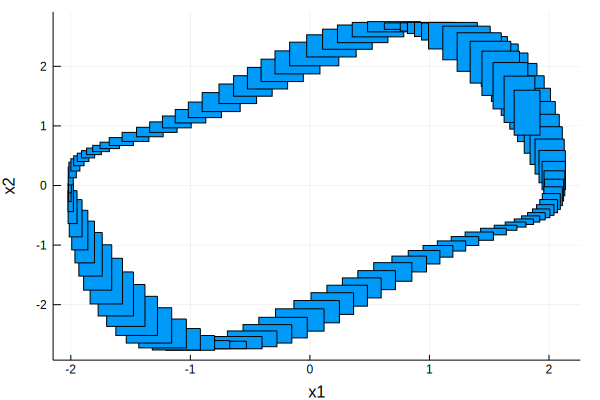

In [77]:
plot(Rsol_H, xlab="x1", ylab="x2")

In [42]:
typeof(TM)

SubArray{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},2,Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}

In [35]:
p1 = TM[1]

  1.4 + 0.15000000000000013 x₁ + [0, 0]

In [37]:
typeof(p1)

TaylorModels.TaylorModel1{TaylorN{Float64},Float64}

In [59]:
p1.dom

[0, 0]

In [75]:
p8 = TM[6]

  2.2329572981136296 - 0.04712884563843239 x₁ + 0.047426019469483514 x₂ - 0.001685522838480088 x₁² - 0.0008867379850040321 x₁ x₂ - 6.122083412900732e-6 x₂² + ( - 4.267381052507744 - 1.0866337918169267 x₁ - 0.07451935378394 x₂ - 0.026160020729329787 x₁² - 0.020983334488018125 x₁ x₂ - 0.0002906762738168224 x₂²) t + ( - 5.932873470382306 + 1.2215964945843727 x₁ - 0.2916697196937448 x₂ + 0.3460628172992125 x₁² + 0.01616057430078008 x₁ x₂ - 0.0033383131656721955 x₂²) t² + ( 13.71747891607359 + 5.5439685058298185 x₁ + 0.48012514328802003 x₂ + 0.05792820848543904 x₁² + 0.24886457499528547 x₁ x₂ + 0.004012911925073691 x₂²) t³ + ( 13.28395636963881 - 6.925470840661171 x₁ + 1.1935873833757484 x₂ - 2.6947676412691473 x₁² - 0.1812502203823856 x₁ x₂ + 0.030788119359539325 x₂²) t⁴ + ( - 39.8456973621759 - 20.089806398743516 x₁ - 2.1831810917296397 x₂ + 0.5615282862870664 x₁² - 1.4575957483696014 x₁ x₂ - 0.036174355749077756 x₂²) t⁵ + ( - 26.61780785080378 + 29.41834538078614 x₁ - 3.7604479518397267 

In [68]:
p8.pol

  2.046650929380527 - 0.08974828886480801 x₁ + 0.04386856551534871 x₂ - 0.002178870204402528 x₁² - 0.0017126633943113398 x₁ x₂ - 2.356242759005208e-5 x₂² + 𝒪(‖x‖³) + ( - 4.685755955207542 - 0.9588457196348403 x₁ - 0.09594152421873005 x₂ + 0.0021110528137419505 x₁² - 0.018428342776822235 x₁ x₂ - 0.0005388718736628479 x₂² + 𝒪(‖x‖³)) t + ( - 4.117091700022797 + 1.8273655119318244 x₁ - 0.22126280212916785 x₂ + 0.32640631353564376 x₁² + 0.04430178881203577 x₁ x₂ - 0.0025527287453929602 x₂² + 𝒪(‖x‖³)) t² + ( 15.209665524200915 + 4.095857338437549 x₁ + 0.6361916797517821 x₂ - 0.36141658033816376 x₁² + 0.1960778107697691 x₁ x₂ + 0.008302252844269851 x₂² + 𝒪(‖x‖³)) t³ + ( 4.601159444767697 - 10.20624352394244 x₁ + 0.6654312394619014 x₂ - 2.2549510218038686 x₁² - 0.43698584739284085 x₁ x₂ + 0.019865921610488783 x₂² + 𝒪(‖x‖³)) t⁴ + ( - 42.51900852046024 - 11.039581725805846 x₁ - 2.7952007337183495 x₂ + 3.506311681976186 x₁² - 0.9490871039417321 x₁ x₂ - 0.06559052625300196 x₂² + 𝒪(‖x‖³)) t⁵ + ( 5.